In [1]:
# Common useful packages
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import copy
import spectral

# module that is useful for reloading packages
import importlib

# Scripts associated with the SML4SI textbook
import hyperspectral_gta_data as hsi_data
import scripts_M2 as sm2

# set the directory where data will be downloaded and accessed
# (This directory will be saved in a config file and used each time you use hyperspectral_gta_data, 
# so you don't need to run the 'set_data_dir' function every time you use hyperspectral_gta_data.)
hsi_data.set_data_dir('C:/spectral_data')

# Part 1: Open the image and load the data as a numpy array.

In [2]:
# Here are the datasets available through the hyperspectral_gta_data package
hsi_data.available_datasets()

Available Images:
 WashingtonDC
 MicroscenePolymers
 FabricVehicleDetecitonRIT
 VegBaccharisUPWINS
 PaintDetectionUPWINS


In [3]:
# To download and use the polymers image:
hsi_data.download('MicroscenePolymers')
fname = hsi_data.get_fname('MicroscenePolymers')

Filename: C:/spectral_data\spectral_images\Microscene_Polymers/reflectance_image_polymers


In [4]:
# Open the image and read into an array
im = spectral.envi.open(fname+'.hdr', fname)
wl = np.asarray(im.bands.centers)
# Load the image into memory
im.Arr = im.load()
print(f'Shape of Im.Arr = {im.Arr.shape}')
im.List = np.reshape(im.Arr, (im.nrows*im.ncols, im.nbands))
print(f'Shape of im.List = {im.List.shape}')

Shape of Im.Arr = (852, 384, 452)
Shape of im.List = (327168, 452)


In [5]:
# load the associated ground truth image
fname_gt = 'ground_truth_images/reflectance_image_polymers_surfaces.txt'
file1 = open(fname_gt, 'r')
Lines = file1.readlines()

# Strips the newline character
groundtruth_classes = {}
class_names = []

classIndex = 0
idx = 0
x = 0
for line in Lines:
    
    if line[0]==';':
        line = line.strip()
        #  reading the header info
        if line[:11] == '; ROI name:':
            name = line[12:]
            class_names.append(name)
            groundtruth_classes[name] = {'classIndex': classIndex, 'locations': []}
            classIndex = classIndex + 1
        if line[:11] == 'ROI npts:':
            groundtruth_classes[name]['npts'] = float(line[12:])
            
    else:
        line = line.strip()
        # reading the data
        if len(line)==0:
            # blank line - swtch to next class
            idx = idx + 1
        else:
            loc = line.split(' ') # read the locations, split by spaces
            loc = [i for i in loc if i != '']  # remove blank spaces
            loc = [loc[2],loc[1]] # get the x and y coords
            groundtruth_classes[class_names[idx]]['locations'].append(loc)

# Iterate throught the classes and color the ground truth image for each pixel in the ground truth:
gt_im = np.zeros((im.nrows,im.ncols))
for key in groundtruth_classes.keys():
    print(f'Name: {key}')
    idx = groundtruth_classes[key]['classIndex']
    print(f'Index: {idx}')
    locations = groundtruth_classes[key]['locations']
    print(f'Number of points: {len(locations)}')
    print(' ')
    for x,y in locations:
        gt_im[int(x),int(y)] = int(idx)+1

gt_list = np.reshape(gt_im, (im.nrows*im.ncols))


Name: surge_protector_hard
Index: 0
Number of points: 1501
 
Name: ping_pong_ball
Index: 1
Number of points: 320
 
Name: red_lid
Index: 2
Number of points: 7371
 
Name: medicine_bottle_cap
Index: 3
Number of points: 252
 
Name: plastic_bottle
Index: 4
Number of points: 2862
 
Name: red_bubble_wrap
Index: 5
Number of points: 16756
 
Name: clear_bubble_wrap
Index: 6
Number of points: 9997
 
Name: PVC_plumbing_pipe
Index: 7
Number of points: 6765
 
Name: polymer_football
Index: 8
Number of points: 5503
 
Name: glove
Index: 9
Number of points: 2759
 
Name: foil_bag
Index: 10
Number of points: 7807
 
Name: foam_packaging
Index: 11
Number of points: 21831
 


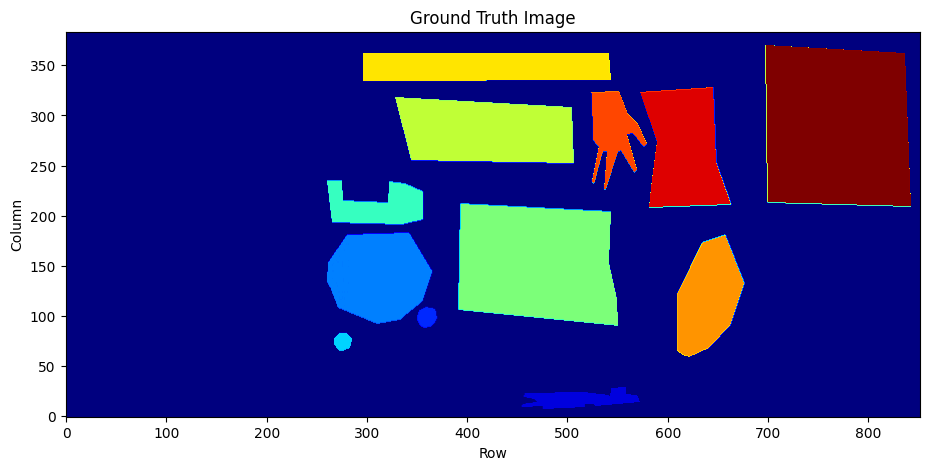

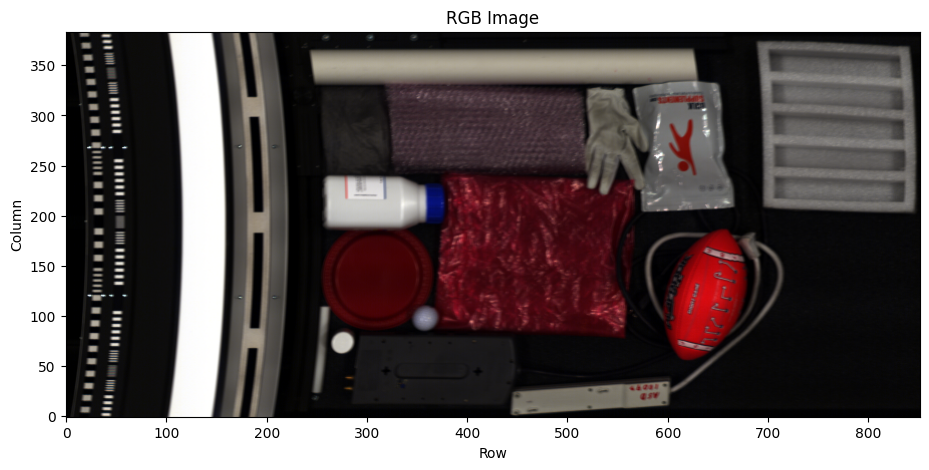

In [6]:
plt.figure(figsize=(15,5)) 
plt.imshow(np.flip(np.rot90(gt_im), axis=0), cmap='jet');
plt.gca().invert_yaxis()  
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('Ground Truth Image')

sm2.display_RGB(im.Arr, wl, rotate=True)
plt.title('RGB Image');

# PART 2: Viewing a scatterplot of the hyperspectral image.

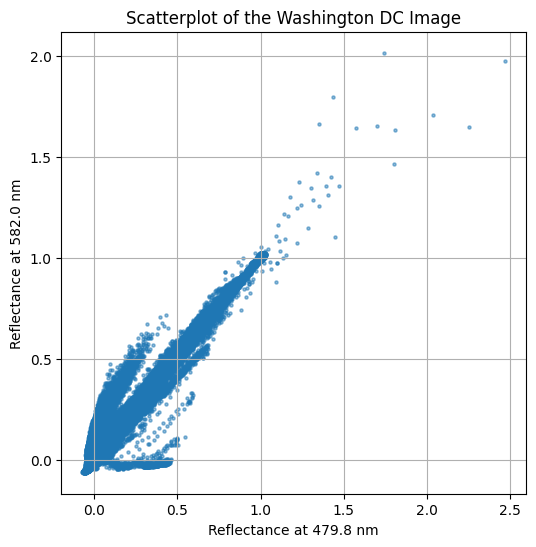

In [7]:
# Create a scatterplot of the data
i1 = 30
i2 = 60

plt.figure(figsize=(6,6))
plt.scatter(im.List[:,i1], im.List[:,i2], s=5, alpha=0.5);
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

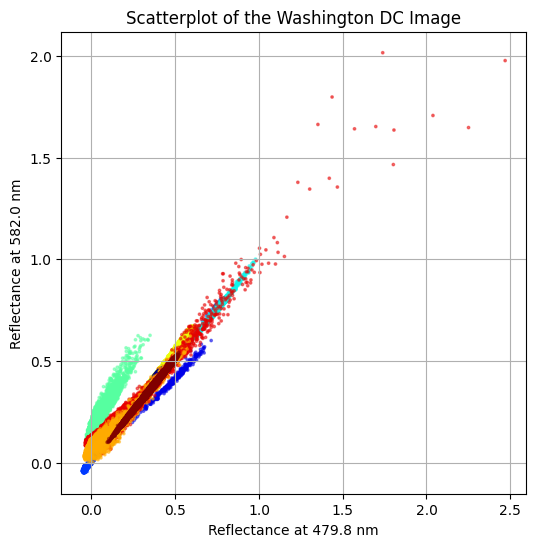

In [8]:
# Create a scatterplot of the data, colored by groundtruth class
i1 = 30
i2 = 60

plt.figure(figsize=(6,6))
gt_indiexes = np.where(gt_list>0)[0] # get hte indices only for pixels in ground truth classes
plt.scatter(im.List[gt_indiexes,i1], im.List[gt_indiexes,i2], c=gt_list[gt_indiexes], s=3, alpha=0.5, cmap='jet');
plt.grid(True)
plt.xlabel(f'Reflectance at {wl[i1]:.1f} nm')
plt.ylabel(f'Reflectance at {wl[i2]:.1f} nm')
plt.title('Scatterplot of the Washington DC Image');

# Part 3: Examining Individual Classes

In [9]:
groundtruth_classes.keys()

dict_keys(['surge_protector_hard', 'ping_pong_ball', 'red_lid', 'medicine_bottle_cap', 'plastic_bottle', 'red_bubble_wrap', 'clear_bubble_wrap', 'PVC_plumbing_pipe', 'polymer_football', 'glove', 'foil_bag', 'foam_packaging'])

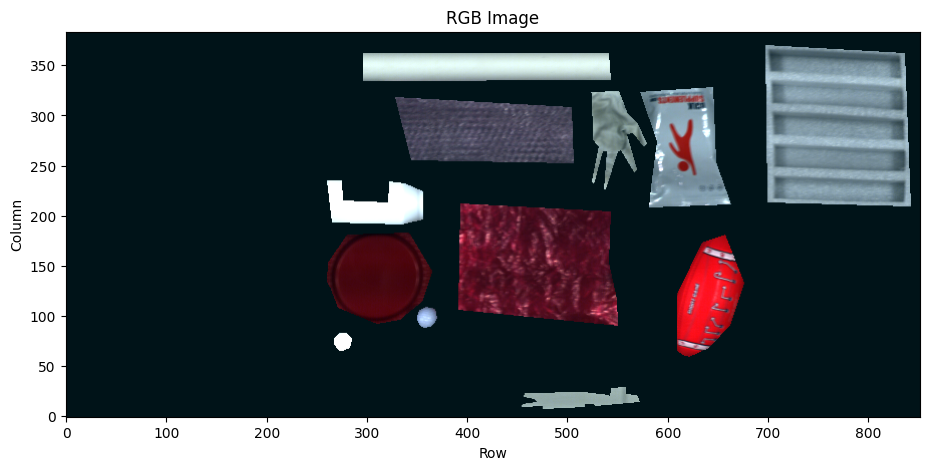

In [10]:
class_only_image = np.zeros((im.nrows, im.ncols, im.nbands))
for class_name in groundtruth_classes.keys():
    for x,y in groundtruth_classes[class_name]['locations']:
        class_only_image[int(x), int(y), :] = im.Arr[int(x), int(y), :]

sm2.display_RGB(class_only_image, wl, stretch_pct=[0,99], rotate=True)
plt.title('RGB Image');

In [13]:
# Compute the common mean for LDA
nClasses = len(groundtruth_classes.keys())
class_means = np.zeros((nClasses, im.nbands))
class_covariances = np.zeros((nClasses, im.nbands, im.nbands))
C = np.zeros((im.nbands,im.nbands))

class_indices = np.unique(gt_list).astype(int)
for idx in class_indices:
    # skip idx==0 because that corresponds to the unlabeled (background) class
    if idx > 0: 
        class_locations = np.where(gt_list==idx)[0]
        num_class_spectra = len(class_locations) # N_i
        class_spectra = im.List[class_locations,:]
        class_means[idx-1,:] = np.mean(class_spectra, axis=0) # \mu_i
        class_covariances[idx-1,:,:] = np.cov(class_spectra.T) # \Sigma_i
        C = C + num_class_spectra*class_covariances[idx-1,:,:]

num_labeled_spectra = np.sum(gt_list>0)
C = C/num_labeled_spectra  # \Sigma

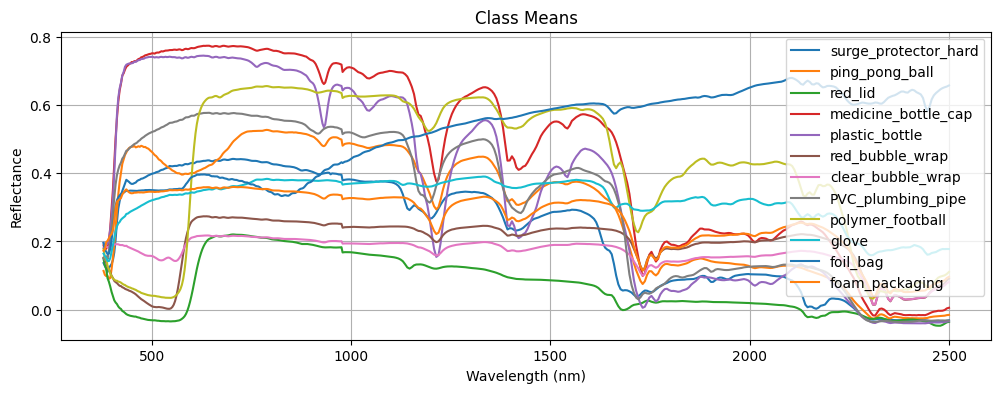

In [14]:
class_names = list(groundtruth_classes.keys())
nClasses = len(class_names)
plt.figure(figsize=(12,4))
for i in range(nClasses):
    plt.plot(wl, class_means[i,:], label=class_names[i])
plt.grid(True)
plt.legend()
plt.title('Class Means')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance');

In [15]:
# Fastest method - using whitening and broadcasting to subtract mean

# Compute the eigenvectors, eigenvalues, and whitening matrix
evals,evecs = np.linalg.eig(C)
# truncate the small eigenvalues to stablize the inverse
#evals[evals<tol] = tol
DiagMatrix = np.diag(evals**(-1/2))
W = np.matmul(evecs,DiagMatrix)

WimList = np.matmul(W.T, im.List.T).T

# Compute Mahalanobis Distance to mean for each class, for all pixels
MD_all = np.zeros((im.nrows*im.ncols, nClasses))
for class_idx in range(nClasses):    
    # demean each pixel
    mu = class_means[class_idx,:]
    # whiten the mean
    Wmu = np.matmul(W.T, mu).T
    # subtract whitened mean from whitened data
    WimList_demean = WimList-Wmu
    # compute Mahalanobis Distance
    MDs = np.sum(WimList_demean**2, axis=1)
    MD = np.sqrt(MDs)
    # classify by minimum Mahalanobis distance
    MD_all[:,class_idx] = MD

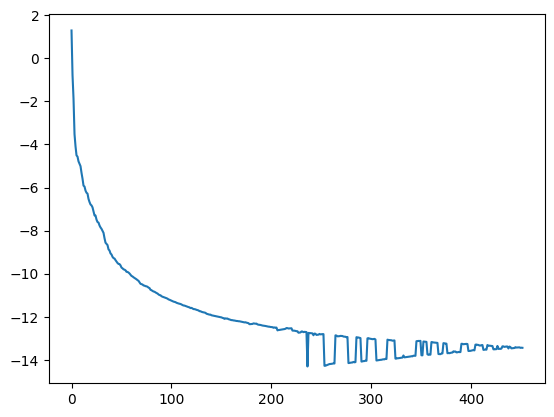

In [16]:
plt.plot(np.log(evals))

In [81]:
LDA_class_list = np.argmin(MD_all, axis=1)
LDA_class_image = np.reshape(LDA_class_list, (im.nrows,im.ncols))

# Viewing Results

Text(0.5, 1.0, 'LDA Class Prediction Image')

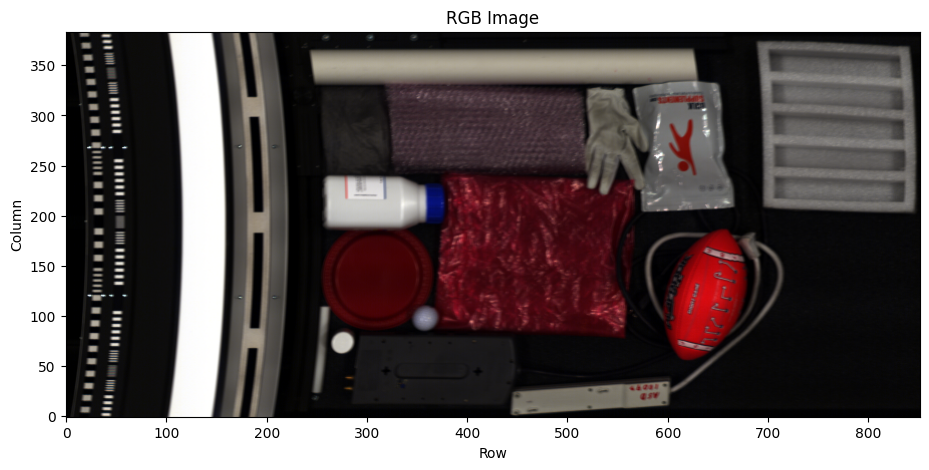

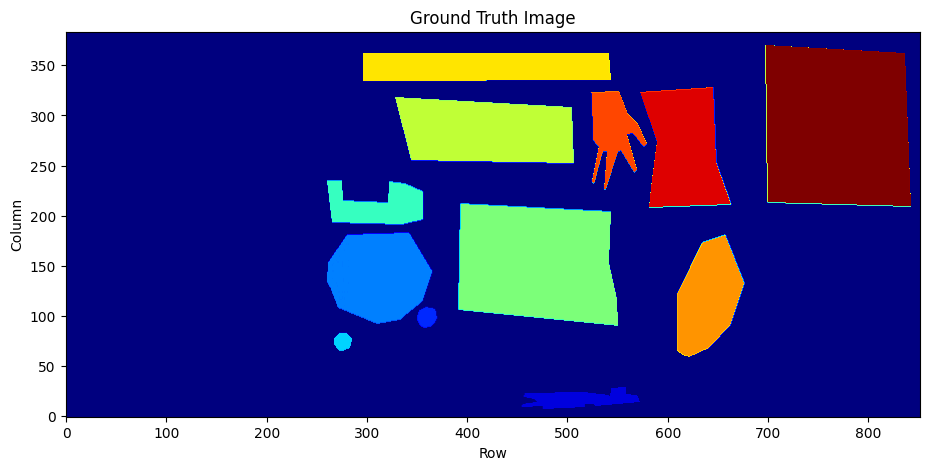

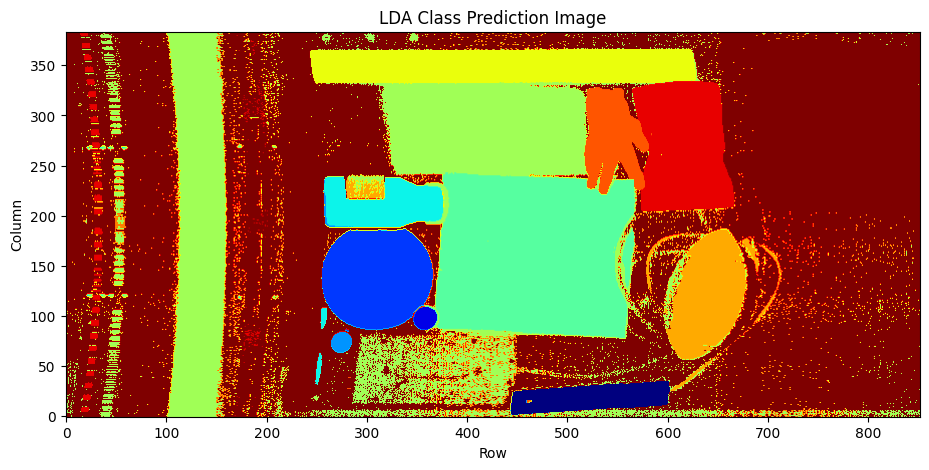

In [82]:
sm2.display_RGB(im.Arr, wl, rotate=True)
plt.title('RGB Image');

plt.figure(figsize=(15,5)) 
plt.imshow(np.flip(np.rot90(gt_im), axis=0), cmap='jet');
plt.gca().invert_yaxis()  
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('Ground Truth Image')

plt.figure(figsize=(15,5)) 
plt.imshow(np.flip(np.rot90(LDA_class_image), axis=0), cmap='jet');
plt.gca().invert_yaxis()  
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('LDA Class Prediction Image')

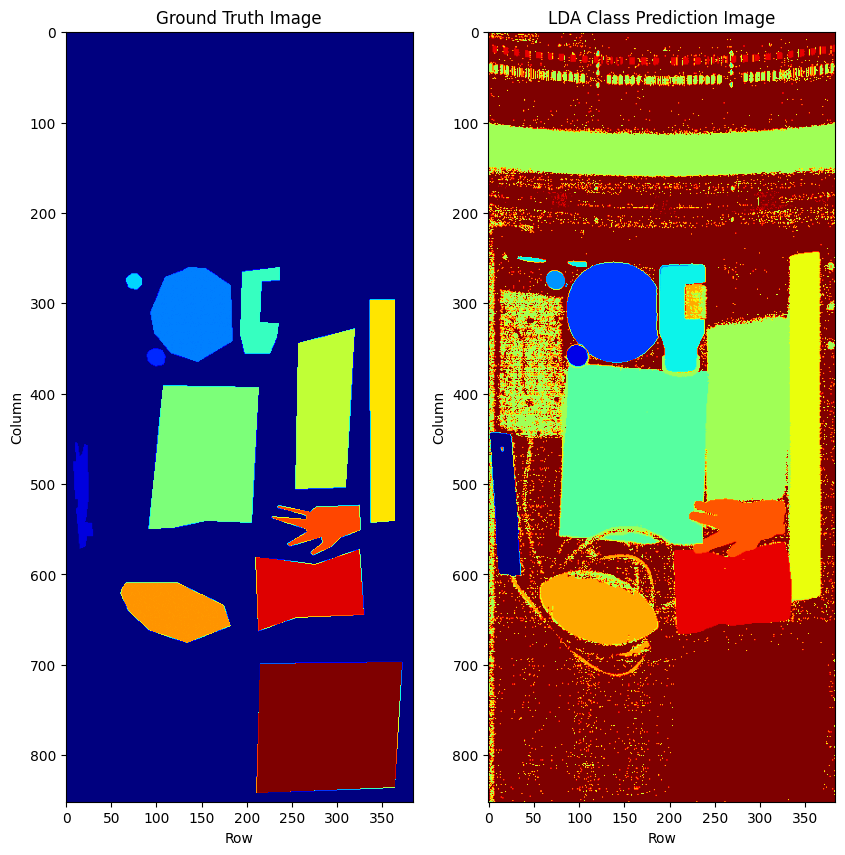

In [83]:
plt.figure(figsize=(10,10)) 

plt.subplot(1,2,1)
plt.imshow(gt_im, cmap='jet');
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('Ground Truth Image')

plt.subplot(1,2,2)
plt.imshow(LDA_class_image, cmap='jet');
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('LDA Class Prediction Image');

# SettingThresholds

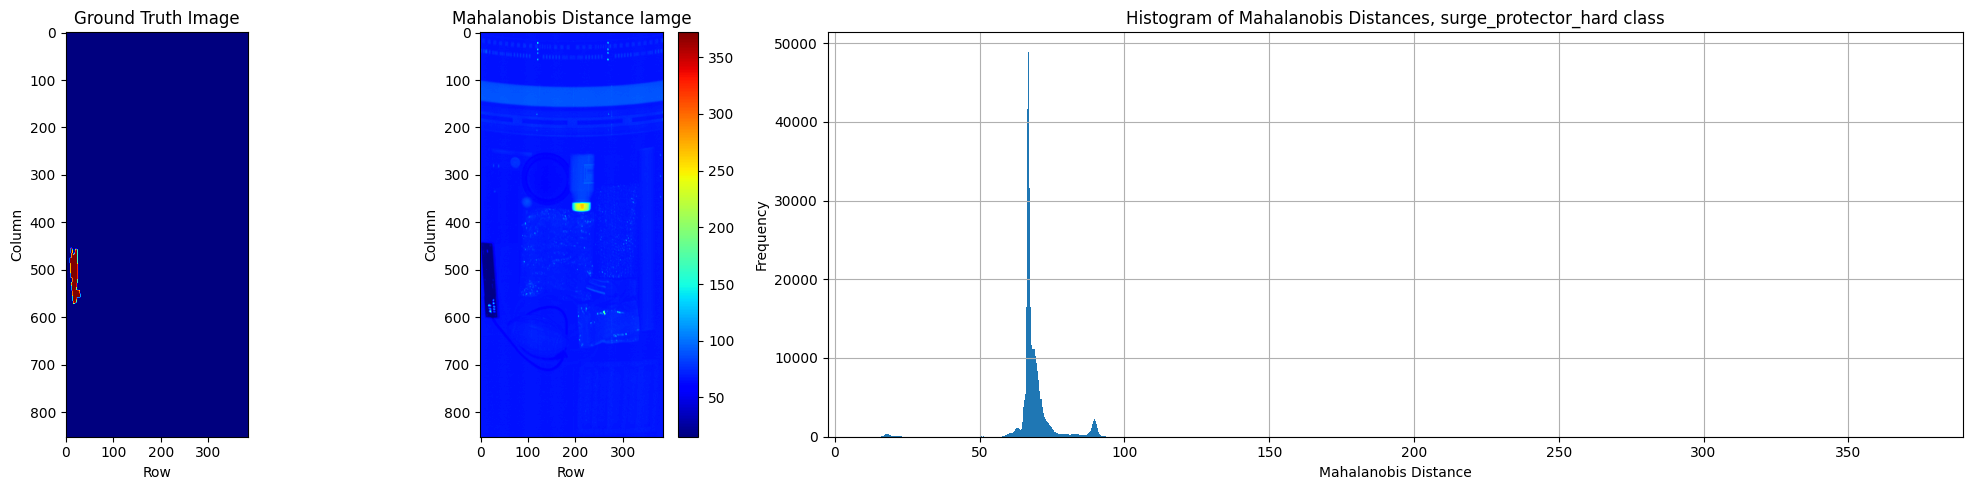

In [20]:
# Class 1: surge protector hard-plastic part
class_idx = 0
class_name = class_names[class_idx]
# create an image with 1 => in the ground truth for this class, 0 => not in the ground truth for this class
class_im = (gt_im==(class_idx+1) ) 
MD_class = MD_all[:,class_idx].flatten()
MD_im = np.reshape(MD_class, (im.nrows,im.ncols))

fig = plt.figure(figsize=(20,5)) 
ax1 = plt.subplot2grid(shape=(1, 5), loc=(0, 0))
ax2 = plt.subplot2grid(shape=(1, 5), loc=(0, 1))
ax3 = plt.subplot2grid(shape=(1, 5), loc=(0, 2), colspan=3)

ax1.imshow(class_im, cmap='jet');
ax1.set_xlabel('Row');
ax1.set_ylabel('Column');
ax1.set_title('Ground Truth Image')

cax = ax2.imshow(MD_im, cmap='jet');
ax2.set_xlabel('Row');
ax2.set_ylabel('Column');
ax2.set_title('Mahalanobis Distance Iamge');
fig.colorbar(cax, ax=ax2)

ax3.hist(MD_class, bins=1000);
ax3.grid(True)
ax3.set_xlabel('Mahalanobis Distance');
ax3.set_ylabel('Frequency');
ax3.set_title(f'Histogram of Mahalanobis Distances, {class_name} class');

plt.tight_layout()

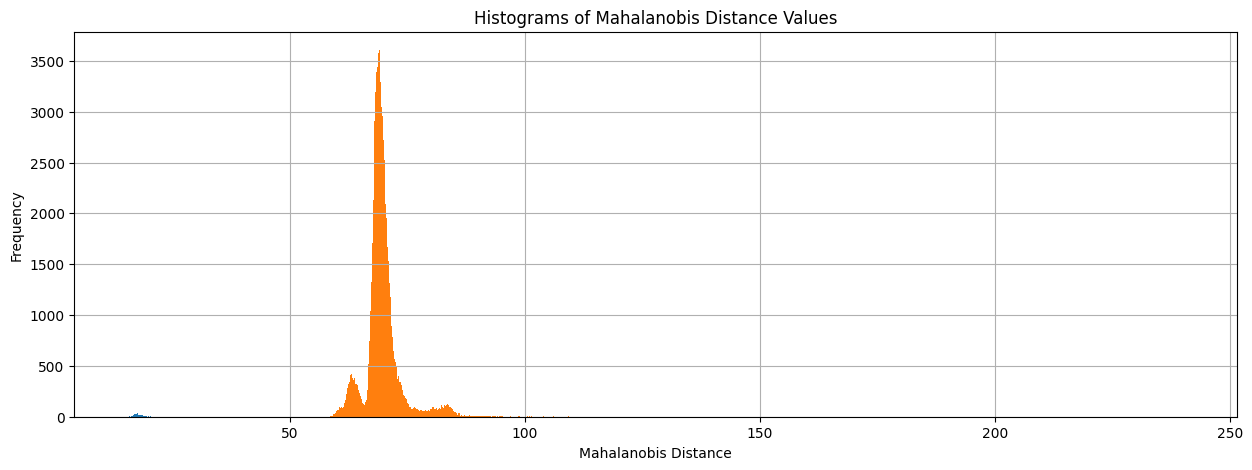

In [21]:
# Plot within-class and out-of-class histograms

MD_within_class = MD_class[np.where(gt_list==(class_idx+1))[0]]
MD_other_classes = MD_class[np.where(gt_list>(class_idx+1))[0]]
plt.figure(figsize=(15,5))
plt.hist(MD_within_class, bins=1000);
plt.hist(MD_other_classes, bins=1000);
plt.grid(True)
plt.xlabel('Mahalanobis Distance');
plt.ylabel('Frequency');
plt.title('Histograms of Mahalanobis Distance Values');

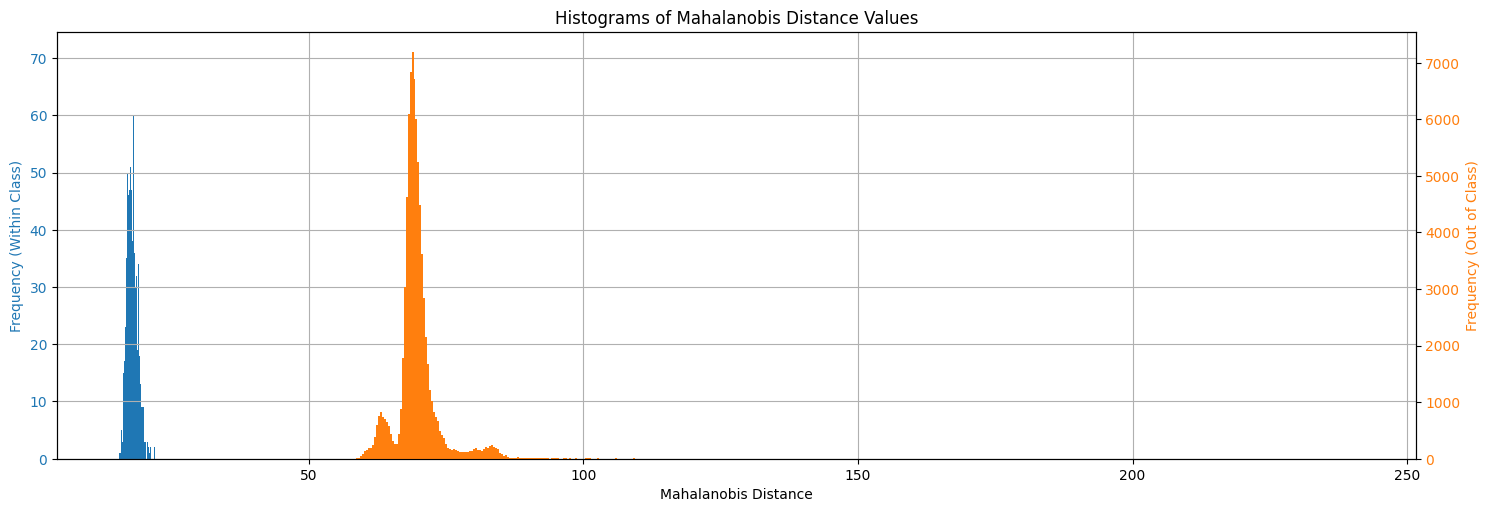

In [22]:
# Plot within-class and out-of-class histograms, giving each their own axis

fig, ax1 = plt.subplots(figsize=(15,5))

color = 'tab:blue'
ax1.set_xlabel('Mahalanobis Distance')
ax1.set_ylabel('Frequency (Within Class)', color=color)
ax1.hist(MD_within_class, bins=500);
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('Frequency (Out of Class)', color=color)  # we already handled the x-label with ax1
ax2.hist(MD_other_classes, bins=500, color=color);
ax2.tick_params(axis='y', labelcolor=color)

ax1.grid(True)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Histograms of Mahalanobis Distance Values');
plt.show()

probability of getting a value of 10 or more from a ch-squared distribution with df = 5 is 0.07523524614651217.
95% of the data in a chisquared distribution with df = 5 has a value less than 11.070497693516355.
 
probability of getting a value of 10 or more from a ch-squared distribution with df = 452 is 1.0.
95% of the data in a chisquared distribution with df = 452 has a value less than 502.5658046278727.
 


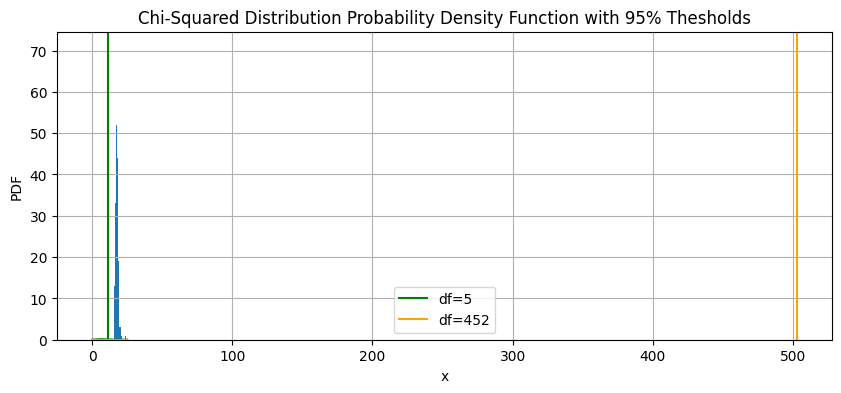

In [31]:
from scipy.stats import chi2

# p-value for a chi-squared distribution
# Assuming degrees of freedom (df) equal to number of bands
df = im.nbands

# plot the probability density function
plt.figure(figsize=(10,4)) 
plt.hist(MD_within_class, bins=500, color='tab:blue')
plt.grid(True)
plt.xlabel('Mahalanobis Distance');
plt.ylabel('Frequency');

x = np.linspace(0, 25, 500) # generate a list of x-values

for df,c in zip([5, im.nbands], ['green','orange']):
    # probability of getting a value of 10 or more from a ch-squared distribution with df = 4
    p1 = chi2.sf(10, df)
    print(f'probability of getting a value of 10 or more from a ch-squared distribution with df = {df} is {p1}.')   
    # probability of getting a value of 10 or more from a ch-squared distribution with df = 4
    thresh = chi2.isf(0.05, df)
    print(f'95% of the data in a chisquared distribution with df = {df} has a value less than {thresh}.')
    y = chi2.pdf(df, x) # compute the PDF at these x-values
    plt.plot(x,y, color=c, label=f'df={df}')
    plt.axvline(thresh, color=c)
    max_idx = np.argmin(np.abs(x-thresh))
    plt.fill_between(x[:max_idx], y[:max_idx], 0, color=c, alpha=.1)
    print(' ')

plt.legend()
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Chi-Squared Distribution Probability Density Function with 95% Thesholds');

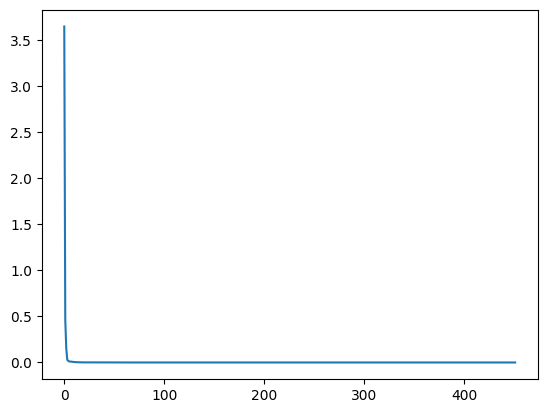

In [40]:
plt.plot(evals)

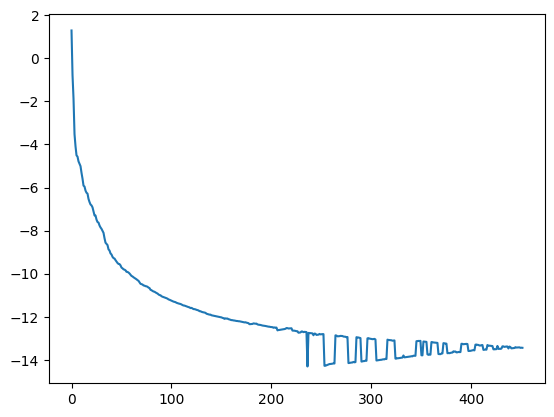

In [39]:
plt.plot(np.log(evals))

In [42]:
for i in range(30):
    variance_fraction = np.sum(evals[:i])/np.sum(evals)
    print(f'with {i} eigenvectors, we capture {100*variance_fraction} percent of the information')

with 0 eigenvectors, we capture 0.0 percent of the information
with 1 eigenvectors, we capture 83.0814653461232 percent of the information
with 2 eigenvectors, we capture 93.61304826657513 percent of the information
with 3 eigenvectors, we capture 97.11619787103423 percent of the information
with 4 eigenvectors, we capture 97.79113307768405 percent of the information
with 5 eigenvectors, we capture 98.17473609533252 percent of the information
with 6 eigenvectors, we capture 98.42718144370431 percent of the information
with 7 eigenvectors, we capture 98.66476648793706 percent of the information
with 8 eigenvectors, we capture 98.85540825276988 percent of the information
with 9 eigenvectors, we capture 99.0255510259499 percent of the information
with 10 eigenvectors, we capture 99.1783354616999 percent of the information
with 11 eigenvectors, we capture 99.29034487192571 percent of the information
with 12 eigenvectors, we capture 99.3757973851732 percent of the information
with 13 eigenv

probability of getting a value of 10 or more from a ch-squared distribution with df = 5 is 0.07523524614651217.
95% of the data in a chisquared distribution with df = 5 has a value less than 11.070497693516355.
 
probability of getting a value of 10 or more from a ch-squared distribution with df = 9 is 0.35048521232336116.
95% of the data in a chisquared distribution with df = 9 has a value less than 16.918977604620448.
 
probability of getting a value of 10 or more from a ch-squared distribution with df = 15 is 0.8197399195036015.
95% of the data in a chisquared distribution with df = 15 has a value less than 24.99579013972863.
 


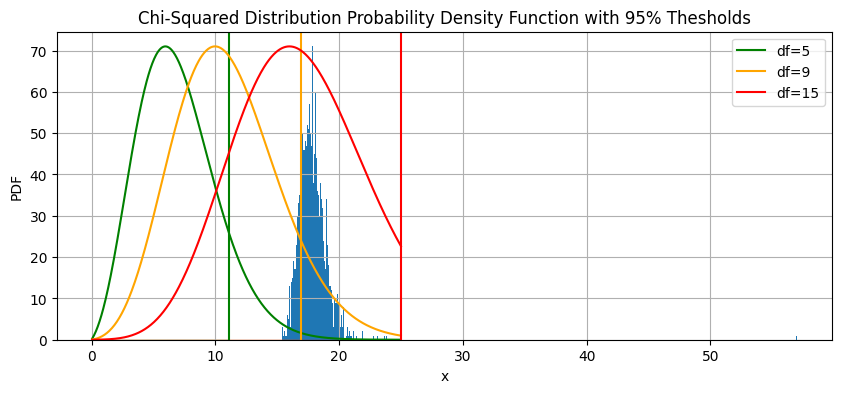

In [58]:
from scipy.stats import chi2

# p-value for a chi-squared distribution
# Assuming degrees of freedom (df) equal to number of bands
df = im.nbands

# plot the probability density function
plt.figure(figsize=(10,4)) 
hvals = plt.hist(MD_within_class, bins=500, color='tab:blue')
plt.grid(True)
plt.xlabel('Mahalanobis Distance');
plt.ylabel('Frequency');

x = np.linspace(0, 25, 500) # generate a list of x-values

for df,c in zip([5, 9, 15], ['green','orange', 'red']):
    # probability of getting a value of 10 or more from a ch-squared distribution with df = 4
    p1 = chi2.sf(10, df)
    print(f'probability of getting a value of 10 or more from a ch-squared distribution with df = {df} is {p1}.')   
    # probability of getting a value of 10 or more from a ch-squared distribution with df = 4
    thresh = chi2.isf(0.05, df)
    print(f'95% of the data in a chisquared distribution with df = {df} has a value less than {thresh}.')
    y = chi2.pdf(df, x) # compute the PDF at these x-values
    plt.plot(x,y*(np.max(hvals[0])/np.nanmax(y)), color=c, label=f'df={df}')
    plt.axvline(thresh, color=c)
    max_idx = np.argmin(np.abs(x-thresh))
    plt.fill_between(x[:max_idx], y[:max_idx], 0, color=c, alpha=.1)
    print(' ')

plt.legend()
plt.xlabel('x')
plt.ylabel('PDF')
plt.title('Chi-Squared Distribution Probability Density Function with 95% Thesholds');

# conclusions:
# 1. Estimating and using the dimension of hyperspectral data is not simple. (See https://www.spiedigitallibrary.org/conference-proceedings-of-spie/6966/69661G/Geometric-estimation-of-the-inherent-dimensionality-of-a-single-material/10.1117/12.776903.full)
# 2. This is because while multivariate normal distributions are good estimates for class distributions, they are not exact.

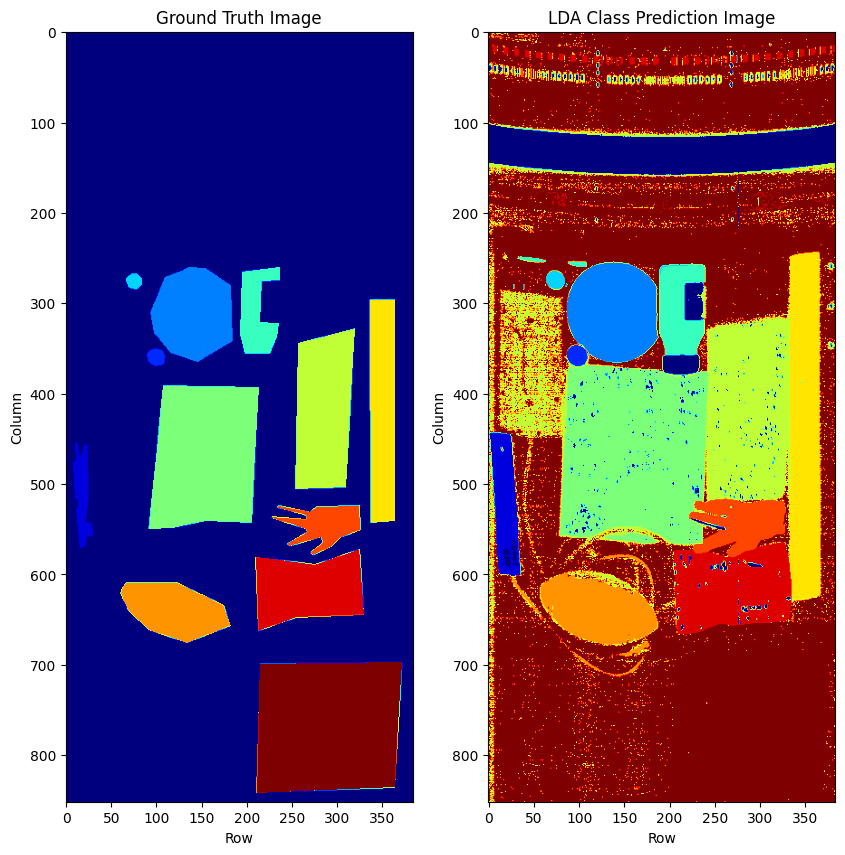

In [74]:
MD_thresh = 45

# Classifying every pixel
LDA_class_list = np.argmin(MD_all, axis=1)
LDA_class_image = np.reshape(LDA_class_list, (im.nrows,im.ncols))

# add an unknown clas (value=0)
LDA_class_list = LDA_class_list + 1
# set pixels with large Mahalanobis distance values to 0
MD_min = np.min(MD_all, axis=1)
LDA_class_list[MD_min>MD_thresh] = 0
# now make the class image
LDA_class_image = np.reshape(LDA_class_list, (im.nrows,im.ncols))



plt.figure(figsize=(10,10)) 

plt.subplot(1,2,1)
plt.imshow(gt_im, cmap='jet');
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('Ground Truth Image')

plt.subplot(1,2,2)
plt.imshow(LDA_class_image, cmap='jet');
plt.xlabel('Row');
plt.ylabel('Column');
plt.title('LDA Class Prediction Image');

# Evaluation Metrics

In [ ]:
# See: https://scikit-learn.org/1.5/api/sklearn.metrics.html


In [105]:
from sklearn.metrics import classification_report

y_true = gt_list[np.where(gt_list>0)[0]]
LDA_class_list = np.argmin(MD_all, axis=1)
y_pred = LDA_class_list[np.where(gt_list>0)[0]]

# modifying for scoring
y_true = y_true - 1
y_true = (y_true).astype(int)

cr = classification_report(y_true, y_pred, target_names=class_names)

print(cr)

                      precision    recall  f1-score   support

surge_protector_hard       1.00      1.00      1.00      1501
      ping_pong_ball       1.00      0.98      0.99       320
             red_lid       1.00      1.00      1.00      7371
 medicine_bottle_cap       1.00      1.00      1.00       252
      plastic_bottle       1.00      1.00      1.00      2862
     red_bubble_wrap       1.00      1.00      1.00     16756
   clear_bubble_wrap       1.00      1.00      1.00      9997
   PVC_plumbing_pipe       1.00      1.00      1.00      6765
    polymer_football       1.00      1.00      1.00      5503
               glove       1.00      1.00      1.00      2759
            foil_bag       1.00      1.00      1.00      7807
      foam_packaging       1.00      1.00      1.00     21831

            accuracy                           1.00     83724
           macro avg       1.00      1.00      1.00     83724
        weighted avg       1.00      1.00      1.00     83724

